## 1. Library Imports


In [65]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates as mdates
import warnings

# Time series analysis
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Forecasting models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


## 2. Data Loading


In [66]:
# Load the dataset
data_file = "COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries_(RAW)_20251125.csv"

print("Loading dataset...")
df_raw = pd.read_csv(data_file, low_memory=False)

print(f"Dataset shape: {df_raw.shape}")
print(f"\nColumns: {len(df_raw.columns)}")
print(f"\nFirst few rows:")
df_raw.head()


Loading dataset...
Dataset shape: (81713, 135)

Columns: 135

First few rows:


,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,inpatient_beds,inpatient_beds_coverage,inpatient_beds_used,inpatient_beds_used_coverage,inpatient_beds_used_covid,inpatient_beds_used_covid_coverage,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_confirmed_coverage,previous_day_admission_adult_covid_suspected,previous_day_admission_adult_covid_suspected_coverage,previous_day_admission_pediatric_covid_confirmed,previous_day_admission_pediatric_covid_confirmed_coverage,previous_day_admission_pediatric_covid_suspected,previous_day_admission_pediatric_covid_suspected_coverage,staffed_adult_icu_bed_occupancy,staffed_adult_icu_bed_occupancy_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid,staffed_icu_adult_patients_confirmed_and_suspected_covid_coverage,staffed_icu_adult_patients_confirmed_covid,staffed_icu_adult_patients_confirmed_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_adult_patients_hospitalized_confirmed_covid,total_adult_patients_hospitalized_confirmed_covid_coverage,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,total_pediatric_patients_hospitalized_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_covid_coverage,total_staffed_adult_icu_beds,total_staffed_adult_icu_beds_coverage,inpatient_beds_utilization,inpatient_beds_utilization_coverage,inpatient_beds_utilization_numerator,inpatient_beds_utilization_denominator,percent_of_inpatients_with_covid,percent_of_inpatients_with_covid_coverage,percent_of_inpatients_with_covid_numerator,percent_of_inpatients_with_covid_denominator,inpatient_bed_covid_utilization,inpatient_bed_covid_utilization_coverage,inpatient_bed_covid_utilization_numerator,inpatient_bed_covid_utilization_denominator,adult_icu_bed_covid_utilization,adult_icu_bed_covid_utilization_coverage,adult_icu_bed_covid_utilization_numerator,adult_icu_bed_covid_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator,geocoded_state,previous_day_admission_adult_covid_confirmed_18-19,previous_day_admission_adult_covid_confirmed_18-19_coverage,previous_day_admission_adult_covid_confirmed_20-29,previous_day_admission_adult_covid_confirmed_20-29_coverage,previous_day_admission_adult_covid_confirmed_30-39,previous_day_admission_adult_covid_confirmed_30-39_coverage,previous_day_admission_adult_covid_confirmed_40-49,previous_day_admission_adult_covid_confirmed_40-49_coverage,previous_day_admission_adult_covid_confirmed_50-59,previous_day_admission_adult_covid_confirmed_50-59_coverage,previous_day_admission_adult_covid_confirmed_60-69,previous_day_admission_adult_covid_confirmed_60-69_coverage,previous_day_admission_adult_covid_confirmed_70-79,previous_day_admission_adult_covid_confirmed_70-79_coverage,previous_day_admission_adult_covid_confirmed_80+,previous_day_admission_adult_covid_confirmed_80+_coverage,previous_day_admission_adult_covid_confirmed_unknown,previous_day_admission_adult_covid_confirmed_unknown_coverage,previous_day_admission_adult_covid_suspected_18-19,previous_day_admission_adult_covid_suspected_18-19_coverage,previous_day_admission_adult_covid_suspected_20-29,previous_day_admission_adult_covid_suspected_20-29_coverage,previous_day_admission_adult_covid_suspected_30-39,previous_day_admission_adult_covid_suspected_30-39_coverage,previous_day_admission_adult_covid_suspected_40-49,previous_day_admission_adult_covid_suspected_40-49_coverage,previ

In [67]:
# Examine basic information about the dataset
print("Dataset Info:")
print("=" * 50)
print(f"Total records: {len(df_raw):,}")
print(f"Date range: {df_raw['date'].min()} to {df_raw['date'].max()}")
print(f"Number of states: {df_raw['state'].nunique()}")
print(f"States: {sorted(df_raw['state'].unique())}")

print("\n\nMissing values per column (top 20):")
missing_counts = df_raw.isnull().sum().sort_values(ascending=False)
print(missing_counts.head(20))


Dataset Info:
Total records: 81,713
Date range: 2020/01/01 to 2024/04/27
Number of states: 54
States: ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY']


Missing values per column (top 20):
geocoded_state                                                      81713
previous_day_admission_pediatric_covid_confirmed_12_17              37049
previous_day_admission_pediatric_covid_confirmed_5_11               37036
previous_day_admission_pediatric_covid_confirmed_0_4                36412
previous_day_admission_pediatric_covid_confirmed_unknown            36296
staffed_icu_pediatric_patients_confirmed_covid                      30149
on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses        22857
previous_week_the

## 3. Data Preprocessing

### 3.1 Select Target Variable and Prepare Data

We will focus on forecasting **`inpatient_beds_used_covid`**, a critical metric for hospital capacity planning.


In [68]:
# Convert date column to datetime
df_raw['date'] = pd.to_datetime(df_raw['date'], format='%Y/%m/%d')

# Select a state for analysis (we'll use a state with good data coverage)
# Let's analyze which states have the most complete data
state_coverage = df_raw.groupby('state')['inpatient_beds_used_covid'].apply(
    lambda x: (x.notna().sum() / len(x)) * 100
).sort_values(ascending=False)

print("State data coverage for 'inpatient_beds_used_covid' (top 10):")
print(state_coverage.head(10))

# Select a state with good coverage (e.g., California or New York)
# For demonstration, we'll use the state with best coverage
selected_state = state_coverage.index[0]
print(f"\nSelected state for analysis: {selected_state} ({state_coverage[selected_state]:.2f}% coverage)")


State data coverage for 'inpatient_beds_used_covid' (top 10):
state
AK    100.0
CA    100.0
AZ    100.0
DC    100.0
CT    100.0
CO    100.0
ID    100.0
IL    100.0
IN    100.0
DE    100.0
Name: inpatient_beds_used_covid, dtype: float64

Selected state for analysis: AK (100.00% coverage)


In [69]:
# Filter data for selected state and prepare time series
target_column = 'inpatient_beds_used_covid'

# Extract data for selected state
df_state = df_raw[df_raw['state'] == selected_state].copy()

# Sort by date
df_state = df_state.sort_values('date').reset_index(drop=True)

# Create time series dataset
df_ts = df_state[['date', target_column]].copy()

# Convert target column to numeric, handling any non-numeric values
df_ts[target_column] = pd.to_numeric(df_ts[target_column], errors='coerce')

print(f"Time series shape: {df_ts.shape}")
print(f"Date range: {df_ts['date'].min()} to {df_ts['date'].max()}")
print(f"Total days: {(df_ts['date'].max() - df_ts['date'].min()).days}")
print(f"\nMissing values in target: {df_ts[target_column].isnull().sum()} ({df_ts[target_column].isnull().sum()/len(df_ts)*100:.2f}%)")
print(f"\nFirst few rows:")
df_ts.head(10)


Time series shape: (1497, 2)
Date range: 2020-03-23 00:00:00 to 2024-04-27 00:00:00
Total days: 1496

Missing values in target: 0 (0.00%)

First few rows:


,date,inpatient_beds_used_covid
0,2020-03-23,3
1,2020-03-24,3
2,2020-03-25,1
3,2020-03-26,2
4,2020-03-27,1
5,2020-03-28,1
6,2020-03-29,1
7,2020-03-30,16
8,2020-03-31,18
9,2020-04-01,11


### 3.2 Handle Missing Values

We'll handle missing values using appropriate methods for time series data.


In [70]:
# Set date as index for time series operations
df_ts = df_ts.set_index('date')

# Check for missing values and visualize the gaps
missing_before = df_ts[target_column].isnull().sum()
print(f"Missing values before processing: {missing_before}")

# Forward fill for short gaps, then backward fill for remaining gaps
df_ts[target_column] = df_ts[target_column].ffill(limit=7)  # Forward fill up to 7 days
df_ts[target_column] = df_ts[target_column].bfill(limit=7)  # Backward fill up to 7 days

# For any remaining missing values, use linear interpolation
df_ts[target_column] = df_ts[target_column].interpolate(method='linear')

# Drop any remaining NaN values (if any)
df_ts = df_ts.dropna()

missing_after = df_ts[target_column].isnull().sum()
print(f"Missing values after processing: {missing_after}")
print(f"\nFinal time series length: {len(df_ts)}")
print(f"Date range: {df_ts.index.min()} to {df_ts.index.max()}")


Missing values before processing: 0
Missing values after processing: 0

Final time series length: 1497
Date range: 2020-03-23 00:00:00 to 2024-04-27 00:00:00


### 3.3 Resampling and Aggregation

Check if we need to resample the data to daily frequency (if data is not already daily).


In [71]:
# Check if we need to resample (ensure daily frequency)
# Create a complete date range
date_range = pd.date_range(start=df_ts.index.min(), end=df_ts.index.max(), freq='D')

# Reindex to ensure daily frequency
df_ts = df_ts.reindex(date_range)

# Fill any gaps created by reindexing (should be minimal after previous steps)
df_ts[target_column] = df_ts[target_column].interpolate(method='linear')

# Drop any remaining NaN
df_ts = df_ts.dropna()

print(f"After ensuring daily frequency:")
print(f"Length: {len(df_ts)} days")
print(f"Frequency: Daily")
print(f"\nSample statistics:")
print(df_ts[target_column].describe())


After ensuring daily frequency:
Length: 1497 days
Frequency: Daily

Sample statistics:
count    1497.000000
mean       51.360053
std        50.696822
min         0.000000
25%        17.000000
50%        35.000000
75%        63.000000
max       245.000000
Name: inpatient_beds_used_covid, dtype: float64


### 3.4 Train-Validation-Test Split (Respecting Time Order)

For time series, we must split chronologically to avoid data leakage.


In [72]:
# Define split proportions (typical: 70% train, 15% validation, 15% test)
train_size = 0.70
val_size = 0.15
test_size = 0.15

# Calculate split indices
total_len = len(df_ts)
train_end = int(total_len * train_size)
val_end = int(total_len * (train_size + val_size))

# Split the data chronologically
train_data = df_ts.iloc[:train_end].copy()
val_data = df_ts.iloc[train_end:val_end].copy()
test_data = df_ts.iloc[val_end:].copy()

print("Train-Validation-Test Split:")
print("=" * 50)
print(f"Train set: {len(train_data)} days ({train_data.index.min()} to {train_data.index.max()})")
print(f"Validation set: {len(val_data)} days ({val_data.index.min()} to {val_data.index.max()})")
print(f"Test set: {len(test_data)} days ({test_data.index.min()} to {test_data.index.max()})")
print(f"\nProportions: Train={len(train_data)/total_len*100:.1f}%, Val={len(val_data)/total_len*100:.1f}%, Test={len(test_data)/total_len*100:.1f}%")

# Store the target series for easier access
y_train = train_data[target_column]
y_val = val_data[target_column]
y_test = test_data[target_column]


Train-Validation-Test Split:
Train set: 1047 days (2020-03-23 00:00:00 to 2023-02-02 00:00:00)
Validation set: 225 days (2023-02-03 00:00:00 to 2023-09-15 00:00:00)
Test set: 225 days (2023-09-16 00:00:00 to 2024-04-27 00:00:00)

Proportions: Train=69.9%, Val=15.0%, Test=15.0%


### 3.5 Normalization/Standardization

For some models (especially ML-based), we may need to normalize the data. We'll keep the original scale for ARIMA but create a normalized version for ML models.


In [74]:
# Fit scaler on training data only (to avoid data leakage)
scaler = StandardScaler()

# Create normalized versions for ML models
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).flatten()

print("Normalization complete (using StandardScaler)")
print(f"Training data - Original mean: {y_train.mean():.2f}, std: {y_train.std():.2f}")
print(f"Training data - Scaled mean: {y_train_scaled.mean():.2f}, std: {y_train_scaled.std():.2f}")

# Keep original data for ARIMA models, use scaled for ML models


Normalization complete (using StandardScaler)
Training data - Original mean: 67.02, std: 53.13
Training data - Scaled mean: 0.00, std: 1.00


## 4. Exploratory Data Analysis (EDA)

### 4.1 Overall Time Series Visualization


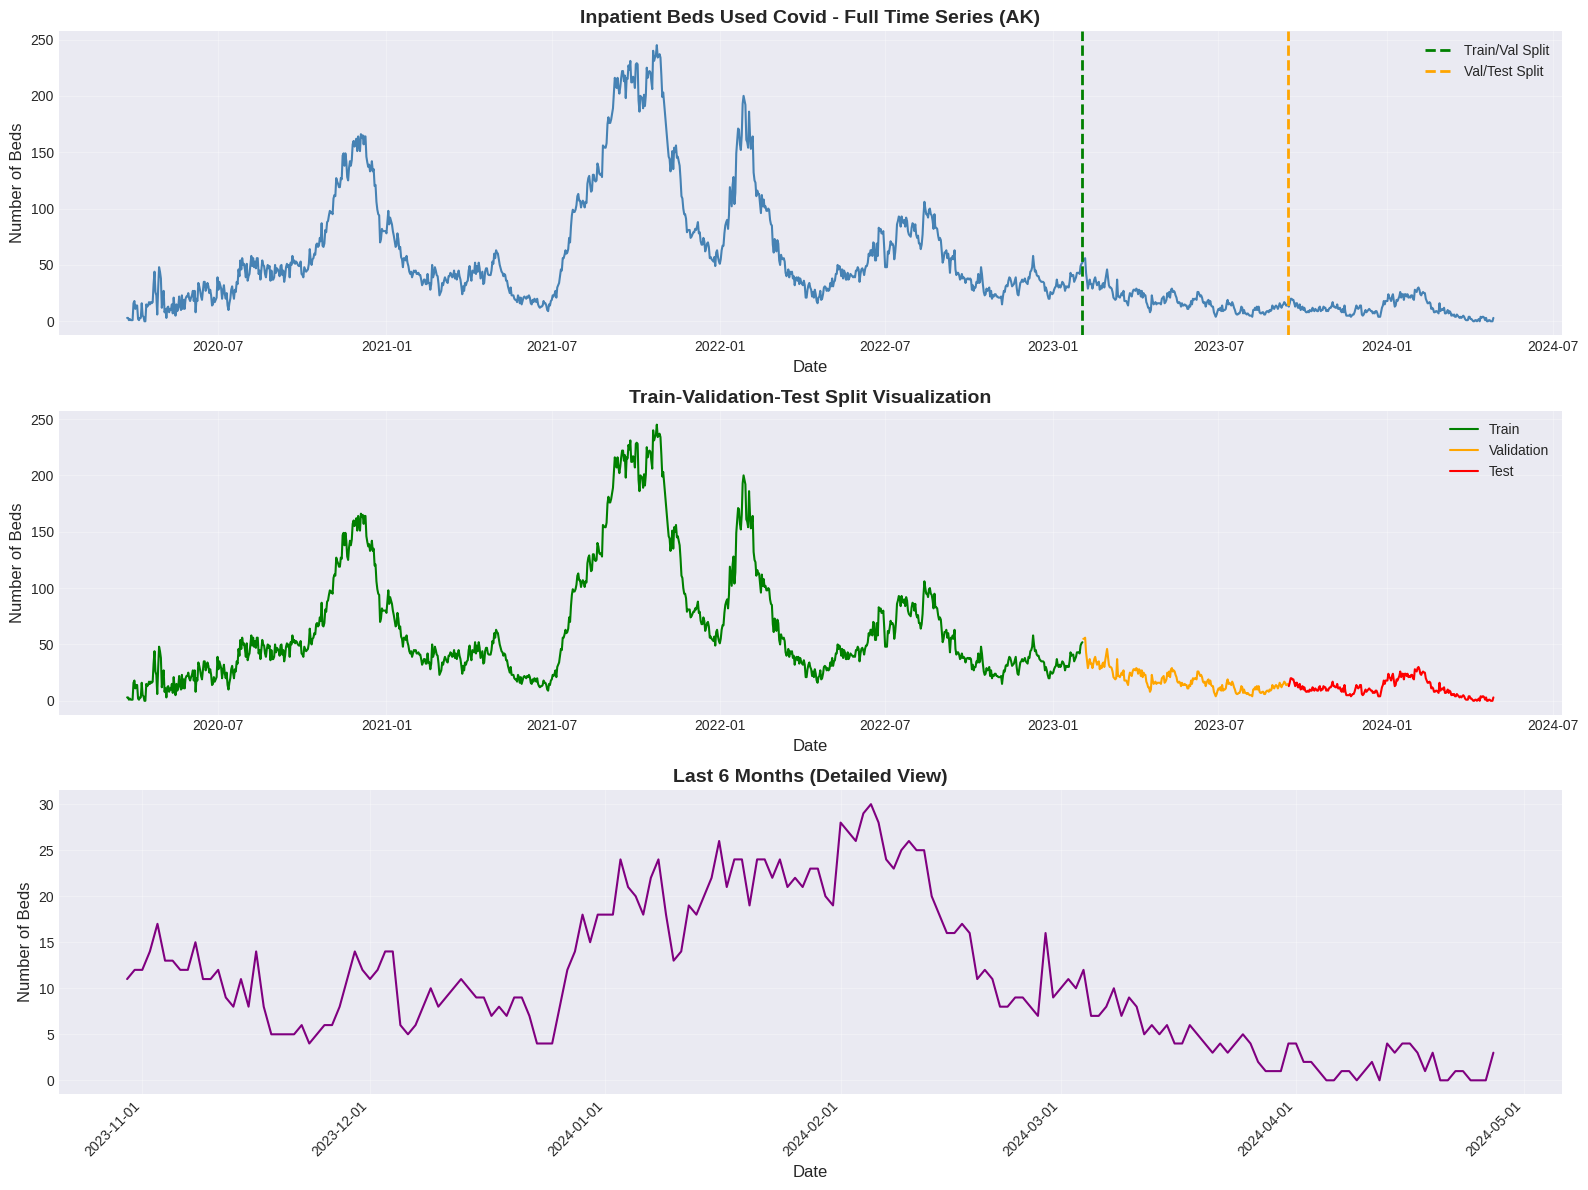

Summary Statistics for AK:
count    1497.000000
mean       51.360053
std        50.696822
min         0.000000
25%        17.000000
50%        35.000000
75%        63.000000
max       245.000000
Name: inpatient_beds_used_covid, dtype: float64


In [75]:
# Create comprehensive time series plot
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Full time series
axes[0].plot(df_ts.index, df_ts[target_column], linewidth=1.5, color='steelblue')
axes[0].axvline(x=train_data.index[-1], color='green', linestyle='--', linewidth=2, label='Train/Val Split')
axes[0].axvline(x=val_data.index[-1], color='orange', linestyle='--', linewidth=2, label='Val/Test Split')
axes[0].set_title(f'{target_column.replace("_", " ").title()} - Full Time Series ({selected_state})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Number of Beds', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Training period
axes[1].plot(train_data.index, train_data[target_column], linewidth=1.5, color='green', label='Train')
axes[1].plot(val_data.index, val_data[target_column], linewidth=1.5, color='orange', label='Validation')
axes[1].plot(test_data.index, test_data[target_column], linewidth=1.5, color='red', label='Test')
axes[1].set_title('Train-Validation-Test Split Visualization', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Number of Beds', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Zoom into last 6 months
recent_data = df_ts[df_ts.index >= df_ts.index.max() - timedelta(days=180)]
axes[2].plot(recent_data.index, recent_data[target_column], linewidth=1.5, color='purple')
axes[2].set_title('Last 6 Months (Detailed View)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Number of Beds', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[2].xaxis.set_major_locator(mdates.MonthLocator())
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"Summary Statistics for {selected_state}:")
print(df_ts[target_column].describe())


### 4.2 Trend Analysis


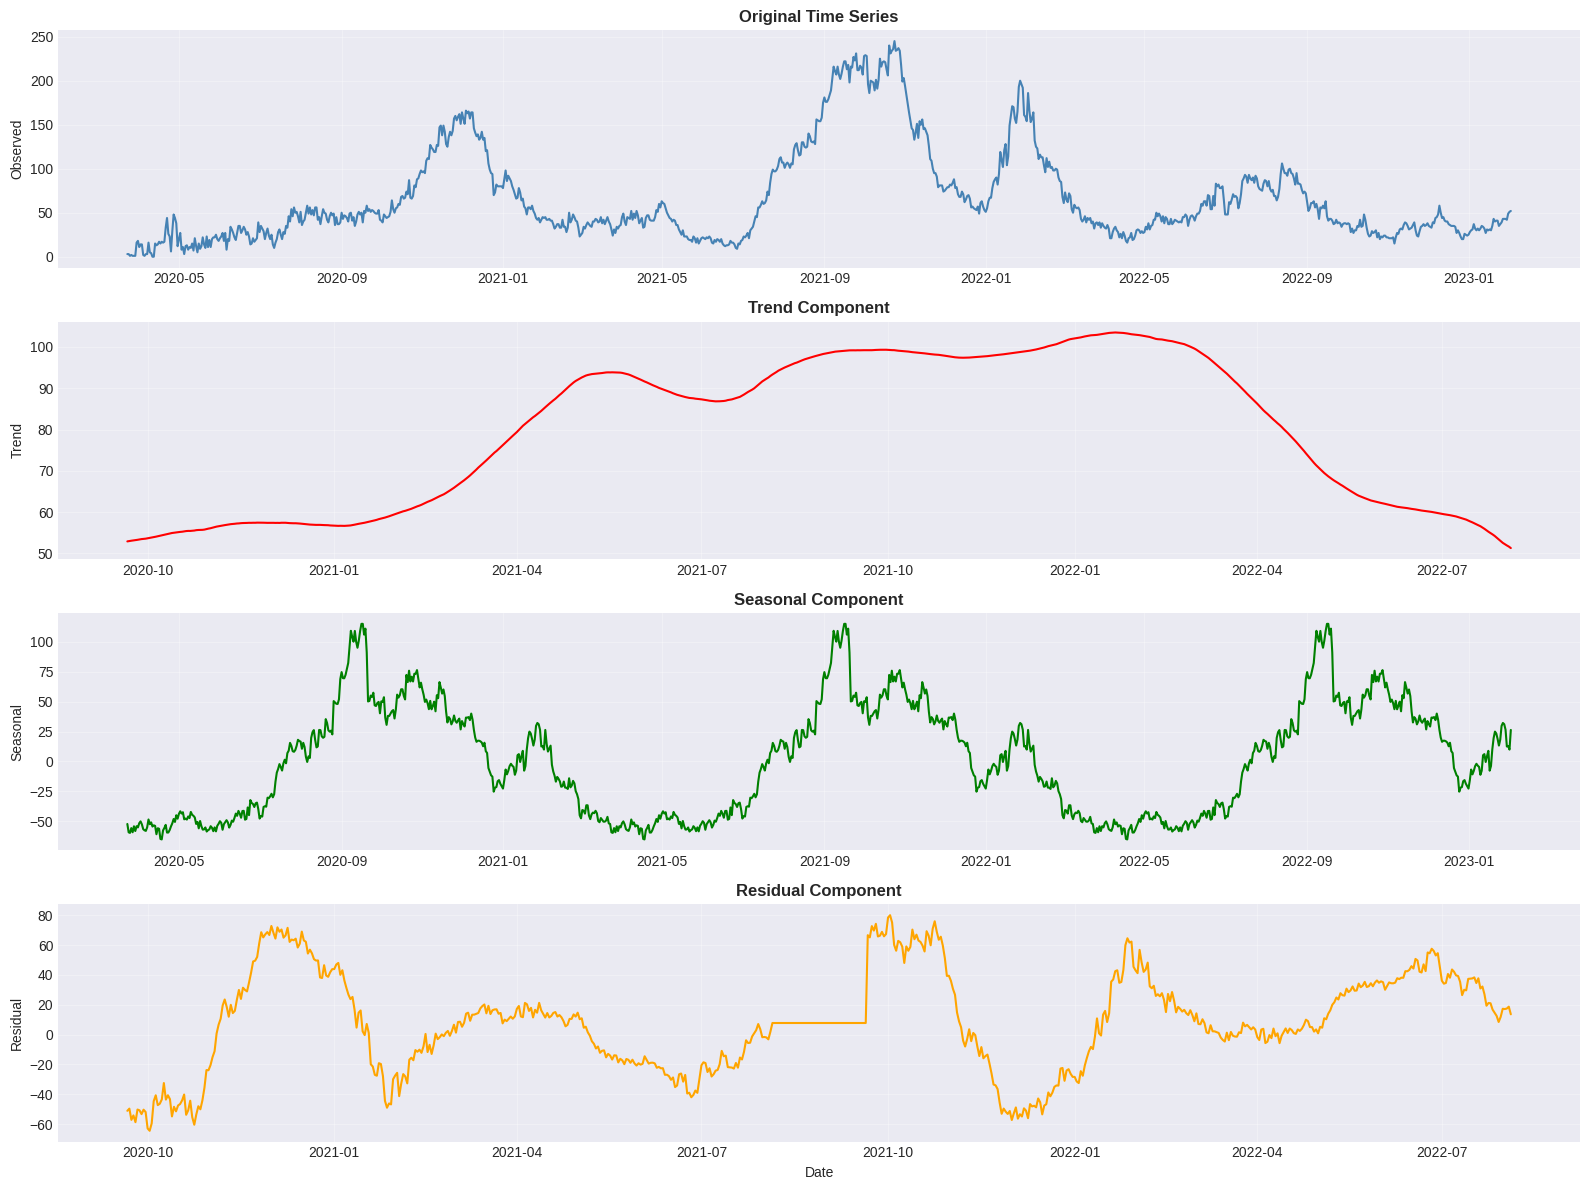

Decomposition Statistics:
Trend variance: 324.65
Seasonal variance: 2150.92
Residual variance: 1066.44


In [76]:
# Decompose the time series to identify trend and seasonality
# Using additive decomposition
decomposition = seasonal_decompose(y_train, model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Original series
axes[0].plot(decomposition.observed.index, decomposition.observed, color='steelblue', linewidth=1.5)
axes[0].set_title('Original Time Series', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Observed', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(decomposition.trend.index, decomposition.trend, color='red', linewidth=1.5)
axes[1].set_title('Trend Component', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Trend', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Seasonal component
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal, color='green', linewidth=1.5)
axes[2].set_title('Seasonal Component', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Seasonal', fontsize=10)
axes[2].grid(True, alpha=0.3)

# Residual
axes[3].plot(decomposition.resid.index, decomposition.resid, color='orange', linewidth=1.5)
axes[3].set_title('Residual Component', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Residual', fontsize=10)
axes[3].set_xlabel('Date', fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print decomposition statistics
print("Decomposition Statistics:")
print(f"Trend variance: {decomposition.trend.var():.2f}")
print(f"Seasonal variance: {decomposition.seasonal.var():.2f}")
print(f"Residual variance: {decomposition.resid.var():.2f}")


### 4.3 Seasonality Analysis


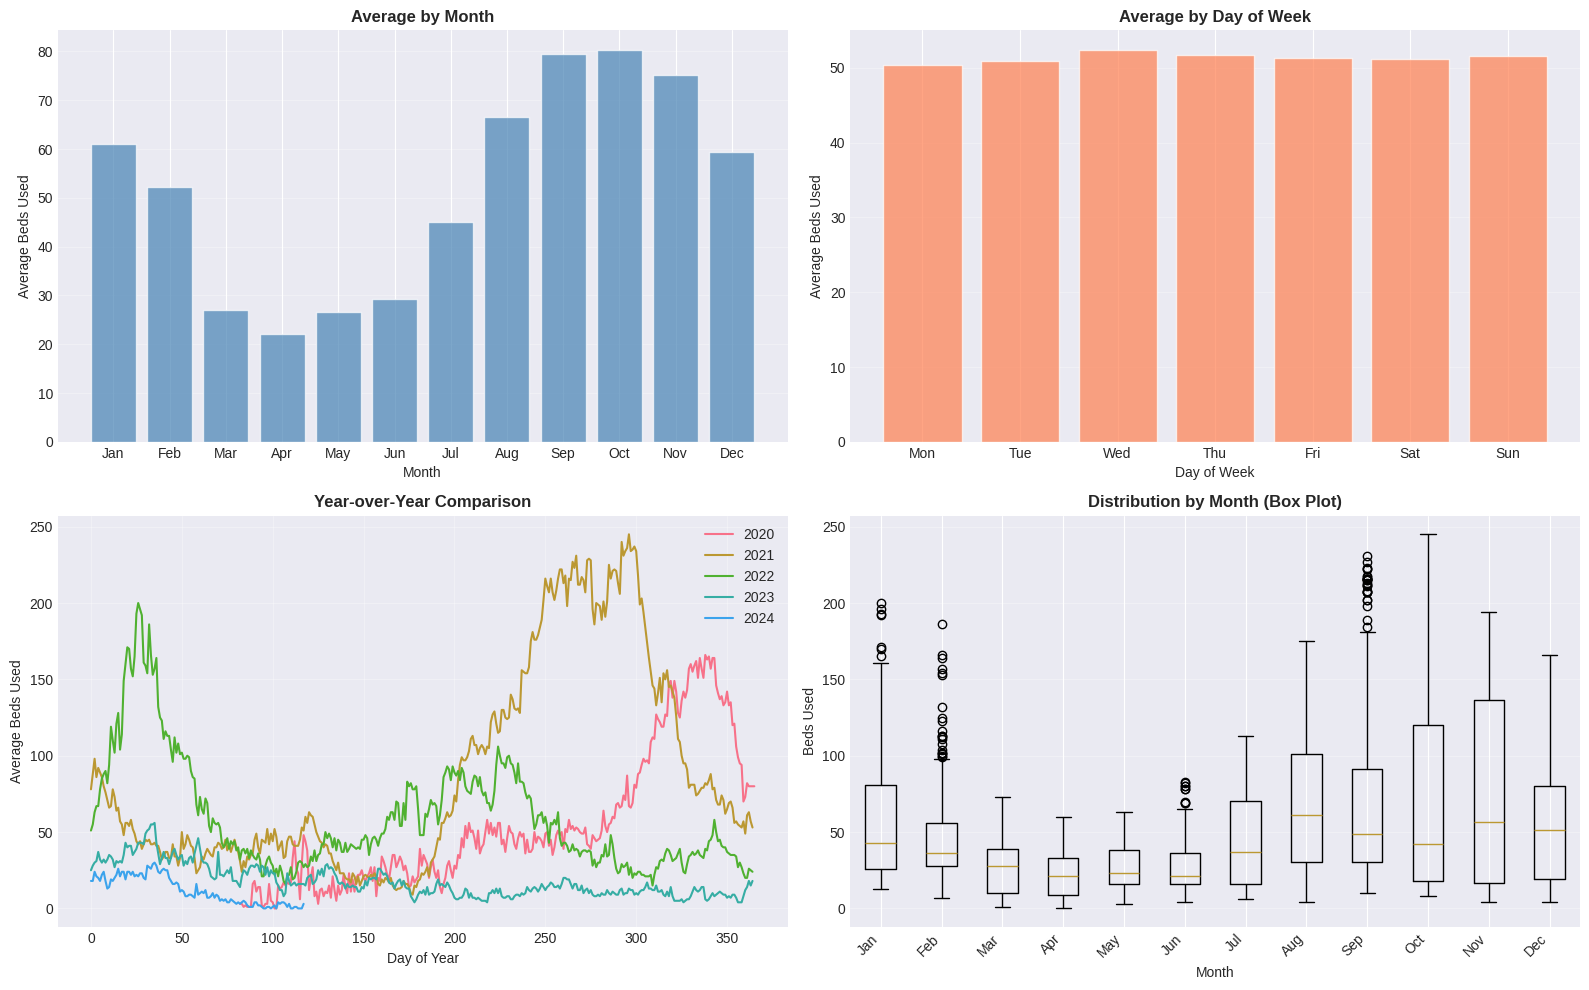

In [77]:
# Analyze weekly and monthly patterns
df_ts['year'] = df_ts.index.year
df_ts['month'] = df_ts.index.month
df_ts['day_of_week'] = df_ts.index.dayofweek
df_ts['week'] = df_ts.index.isocalendar().week

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Monthly patterns
monthly_avg = df_ts.groupby('month')[target_column].mean()
axes[0, 0].bar(monthly_avg.index, monthly_avg.values, color='steelblue', alpha=0.7)
axes[0, 0].set_title('Average by Month', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Month', fontsize=10)
axes[0, 0].set_ylabel('Average Beds Used', fontsize=10)
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Day of week patterns
dow_avg = df_ts.groupby('day_of_week')[target_column].mean()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), dow_avg.values, color='coral', alpha=0.7)
axes[0, 1].set_title('Average by Day of Week', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Day of Week', fontsize=10)
axes[0, 1].set_ylabel('Average Beds Used', fontsize=10)
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(dow_labels)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Year-over-year comparison (if we have multiple years)
yearly_data = df_ts.groupby([df_ts.index.year, df_ts.index.dayofyear])[target_column].mean().unstack(0)
if len(yearly_data.columns) > 1:
    for year in yearly_data.columns:
        axes[1, 0].plot(range(len(yearly_data)), yearly_data[year], label=str(year), linewidth=1.5)
    axes[1, 0].set_title('Year-over-Year Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Day of Year', fontsize=10)
    axes[1, 0].set_ylabel('Average Beds Used', fontsize=10)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Insufficient years for comparison',
                    ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Year-over-Year Comparison', fontsize=12, fontweight='bold')

# Box plot by month
monthly_data = [df_ts[df_ts['month'] == m][target_column].values for m in range(1, 13)]
axes[1, 1].boxplot(monthly_data, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 1].set_title('Distribution by Month (Box Plot)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Month', fontsize=10)
axes[1, 1].set_ylabel('Beds Used', fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


### 4.4 Anomaly Detection


Anomaly Detection Results:
IQR Method - Outliers: 139 (9.29%)
Z-Score Method (|z|>3) - Outliers: 41 (2.74%)
Lower bound (IQR): -52.00
Upper bound (IQR): 132.00


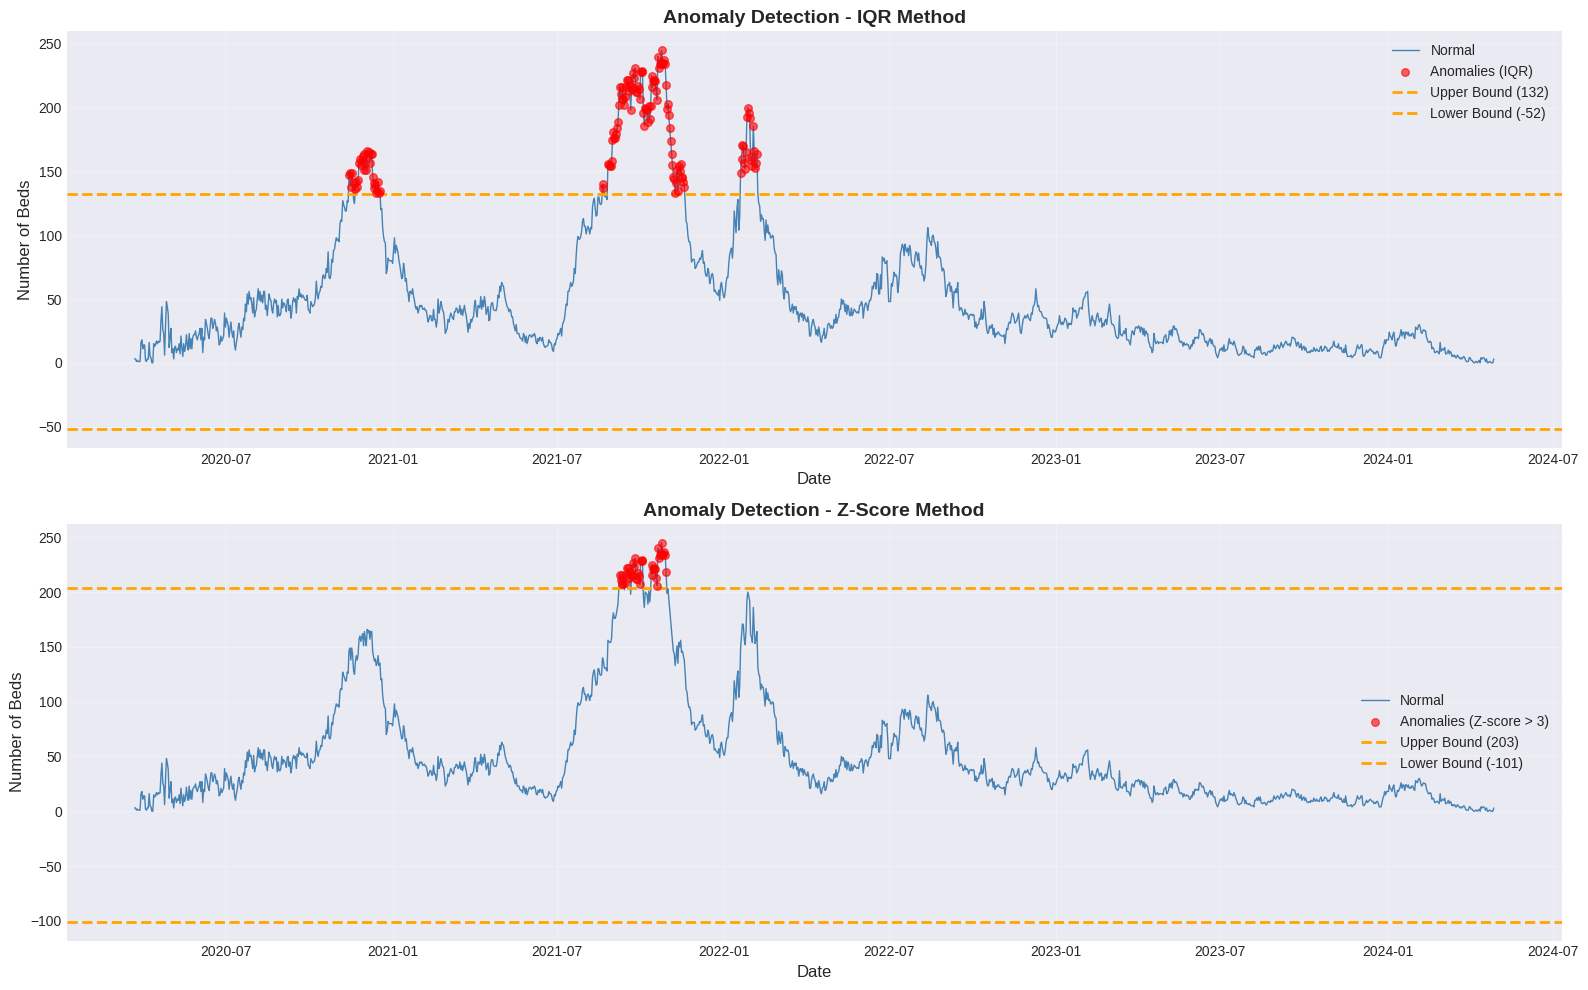

In [78]:
# Detect anomalies using IQR method and Z-score
Q1 = df_ts[target_column].quantile(0.25)
Q3 = df_ts[target_column].quantile(0.75)
IQR = Q3 - Q1

# Define outliers using IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Z-score method
mean_val = df_ts[target_column].mean()
std_val = df_ts[target_column].std()
z_scores = np.abs((df_ts[target_column] - mean_val) / std_val)
outliers_zscore = z_scores > 3

outliers_iqr = (df_ts[target_column] < lower_bound) | (df_ts[target_column] > upper_bound)

print("Anomaly Detection Results:")
print("=" * 50)
print(f"IQR Method - Outliers: {outliers_iqr.sum()} ({outliers_iqr.sum()/len(df_ts)*100:.2f}%)")
print(f"Z-Score Method (|z|>3) - Outliers: {outliers_zscore.sum()} ({outliers_zscore.sum()/len(df_ts)*100:.2f}%)")
print(f"Lower bound (IQR): {lower_bound:.2f}")
print(f"Upper bound (IQR): {upper_bound:.2f}")

# Visualize anomalies
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot with IQR outliers highlighted
axes[0].plot(df_ts.index, df_ts[target_column], linewidth=1, color='steelblue', label='Normal')
axes[0].scatter(df_ts.index[outliers_iqr], df_ts[target_column][outliers_iqr],
                color='red', s=30, alpha=0.6, label='Anomalies (IQR)', zorder=5)
axes[0].axhline(y=upper_bound, color='orange', linestyle='--', linewidth=2, label=f'Upper Bound ({upper_bound:.0f})')
axes[0].axhline(y=lower_bound, color='orange', linestyle='--', linewidth=2, label=f'Lower Bound ({lower_bound:.0f})')
axes[0].set_title('Anomaly Detection - IQR Method', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Number of Beds', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot with Z-score outliers
axes[1].plot(df_ts.index, df_ts[target_column], linewidth=1, color='steelblue', label='Normal')
axes[1].scatter(df_ts.index[outliers_zscore], df_ts[target_column][outliers_zscore],
                color='red', s=30, alpha=0.6, label='Anomalies (Z-score > 3)', zorder=5)
axes[1].axhline(y=mean_val + 3*std_val, color='orange', linestyle='--', linewidth=2,
                label=f'Upper Bound ({mean_val + 3*std_val:.0f})')
axes[1].axhline(y=mean_val - 3*std_val, color='orange', linestyle='--', linewidth=2,
                label=f'Lower Bound ({mean_val - 3*std_val:.0f})')
axes[1].set_title('Anomaly Detection - Z-Score Method', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Number of Beds', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 4.5 Autocorrelation Analysis (ACF and PACF)

ACF and PACF plots help identify patterns and guide ARIMA model parameter selection.


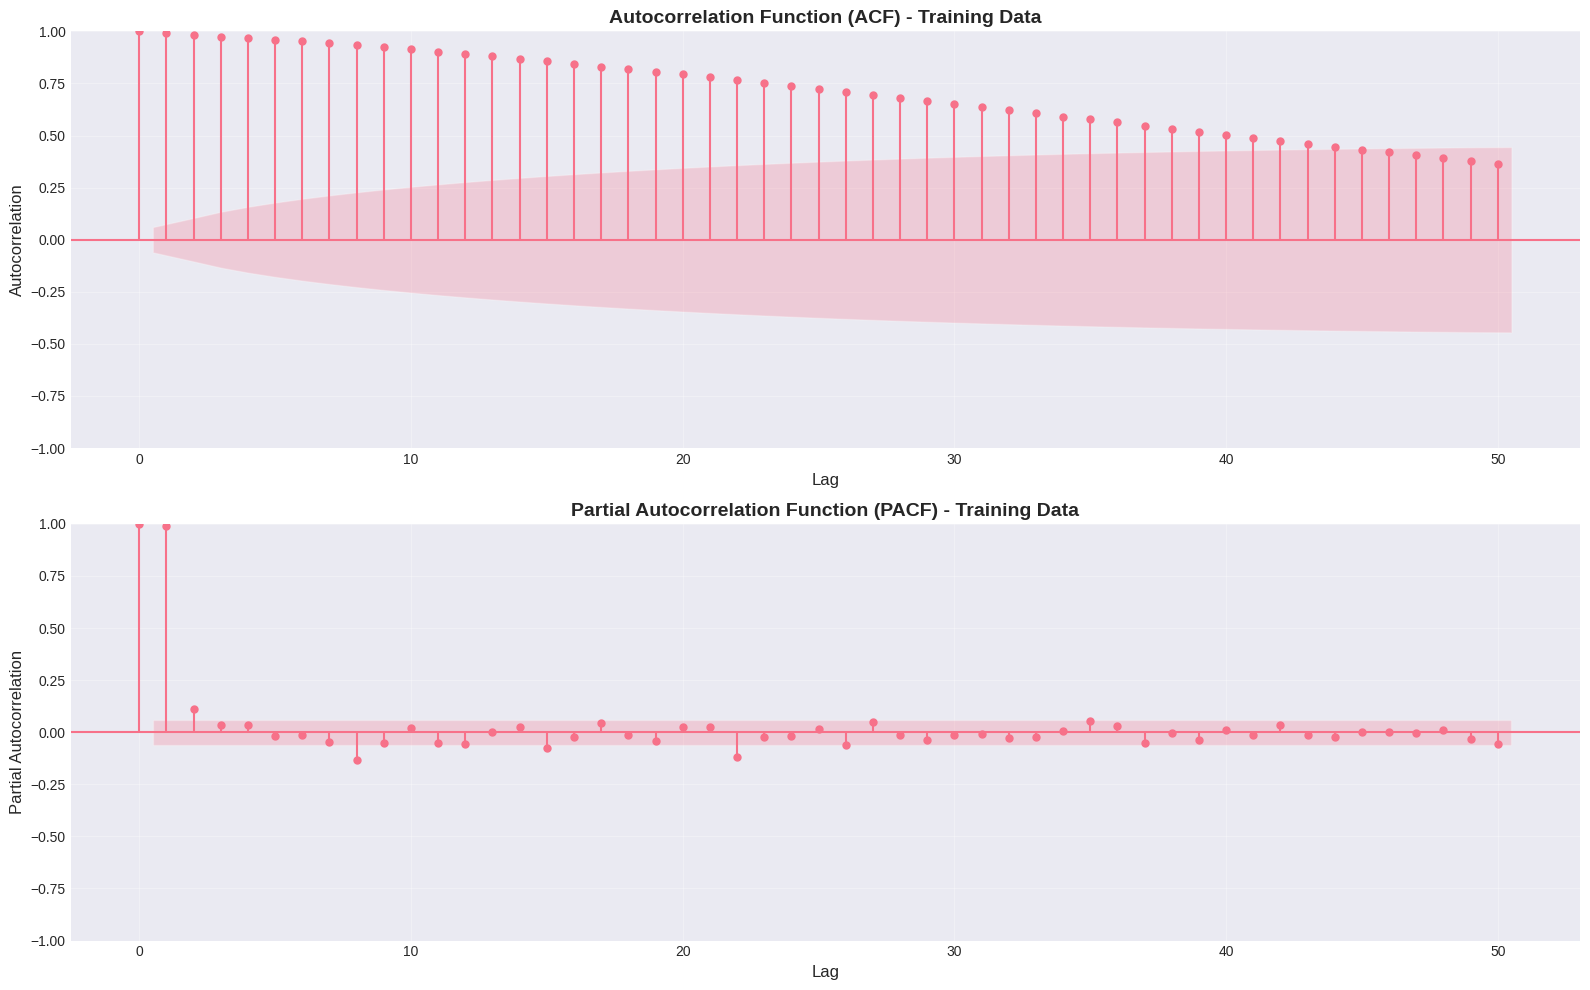

Stationarity Test (Augmented Dickey-Fuller):
ADF Statistic: -3.016689
p-value: 0.033365
Critical Values:
  1%: -3.436746
  5%: -2.864364
  10%: -2.568274

 Series is STATIONARY (p-value <= 0.05)


In [80]:
# Plot ACF and PACF for the training data
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# ACF plot
plot_acf(y_train, lags=50, ax=axes[0], alpha=0.05)
axes[0].set_title('Autocorrelation Function (ACF) - Training Data', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=12)
axes[0].set_ylabel('Autocorrelation', fontsize=12)
axes[0].grid(True, alpha=0.3)

# PACF plot
plot_pacf(y_train, lags=50, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF) - Training Data', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=12)
axes[1].set_ylabel('Partial Autocorrelation', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Stationarity test (Augmented Dickey-Fuller test)
print("Stationarity Test (Augmented Dickey-Fuller):")
print("=" * 50)
adf_result = adfuller(y_train.dropna())
print(f"ADF Statistic: {adf_result[0]:.6f}")
print(f"p-value: {adf_result[1]:.6f}")
print(f"Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.6f}")

if adf_result[1] <= 0.05:
    print("\n Series is STATIONARY (p-value <= 0.05)")
else:
    print("\n Series is NON-STATIONARY (p-value > 0.05)")
    print("   Differencing may be needed for ARIMA models")


## 5. Forecasting Models

We'll implement multiple models:
1. **Baseline Models**: Naive forecast, Moving Average
2. **Advanced Models**: ARIMA, Random Forest (ML-based)


### 5.1 Baseline Model 1: Naive Forecast

The naive forecast simply uses the last observed value as the forecast for all future periods.


Naive Forecast:
Validation forecast: 52.00 (constant)
Test forecast: 15.00 (constant)


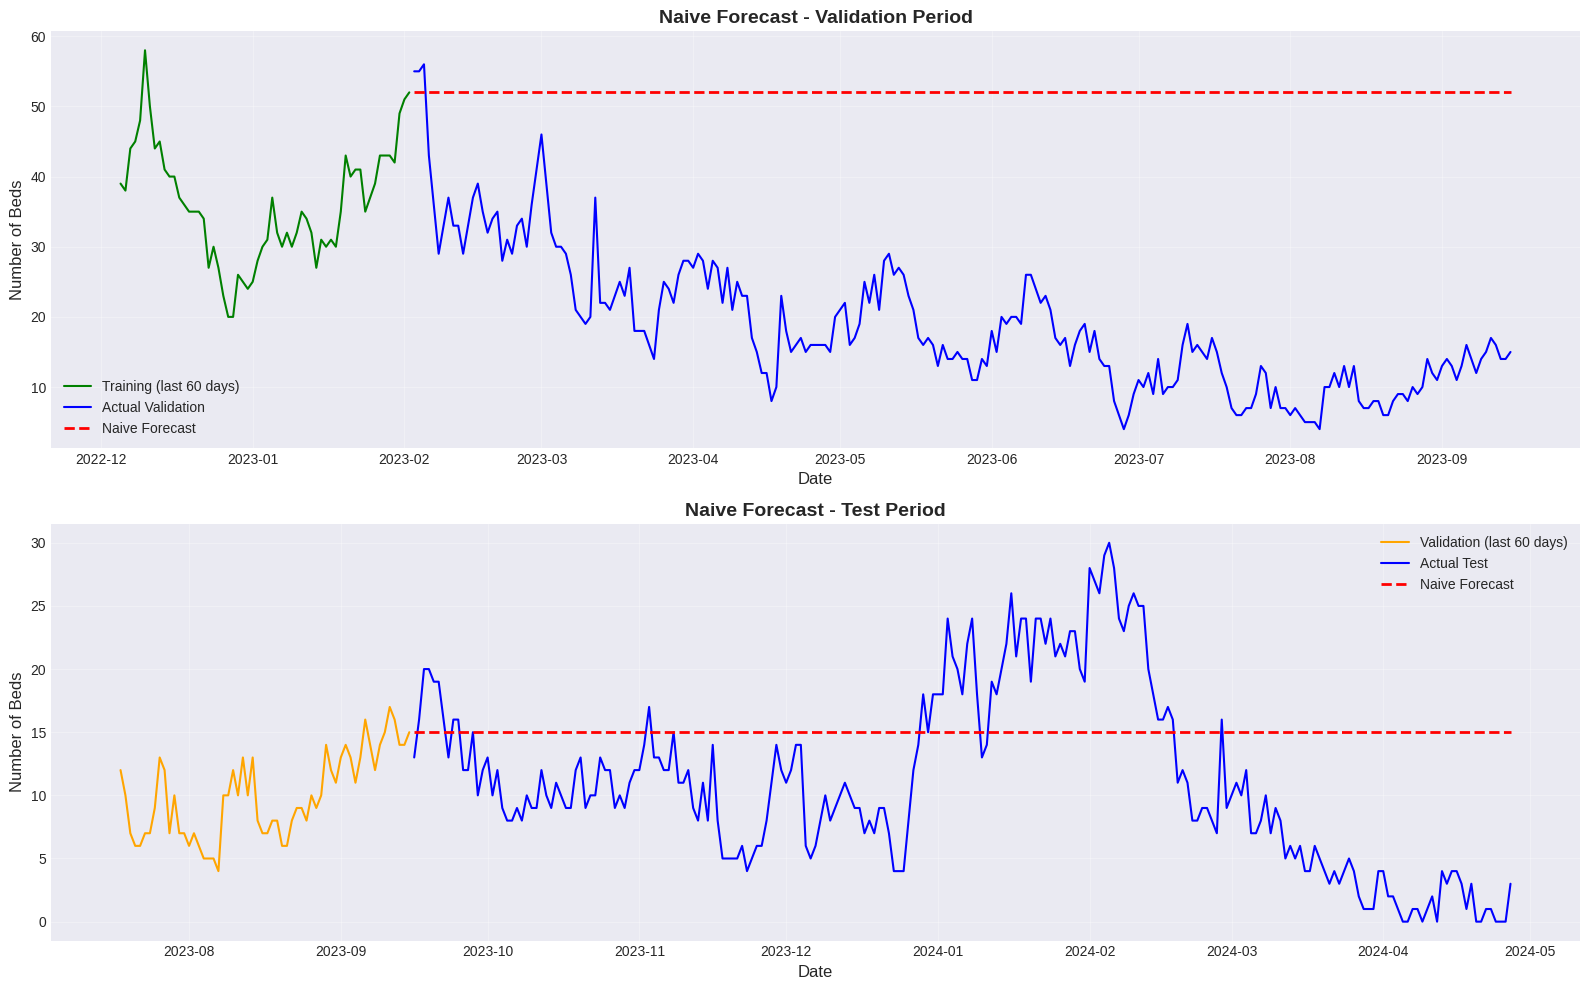

In [81]:
# Naive forecast: use last value from training set
naive_forecast_val = np.full(len(y_val), y_train.iloc[-1])
naive_forecast_test = np.full(len(y_test), y_val.iloc[-1])

# Create forecast series with proper index
naive_forecast_val_series = pd.Series(naive_forecast_val, index=y_val.index)
naive_forecast_test_series = pd.Series(naive_forecast_test, index=y_test.index)

print("Naive Forecast:")
print(f"Validation forecast: {naive_forecast_val[0]:.2f} (constant)")
print(f"Test forecast: {naive_forecast_test[0]:.2f} (constant)")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Validation period
axes[0].plot(y_train.index[-60:], y_train.iloc[-60:], label='Training (last 60 days)', color='green', linewidth=1.5)
axes[0].plot(y_val.index, y_val.values, label='Actual Validation', color='blue', linewidth=1.5)
axes[0].plot(y_val.index, naive_forecast_val_series, label='Naive Forecast', color='red', linestyle='--', linewidth=2)
axes[0].set_title('Naive Forecast - Validation Period', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Number of Beds', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test period
axes[1].plot(y_val.index[-60:], y_val.iloc[-60:], label='Validation (last 60 days)', color='orange', linewidth=1.5)
axes[1].plot(y_test.index, y_test.values, label='Actual Test', color='blue', linewidth=1.5)
axes[1].plot(y_test.index, naive_forecast_test_series, label='Naive Forecast', color='red', linestyle='--', linewidth=2)
axes[1].set_title('Naive Forecast - Test Period', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Number of Beds', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 5.2 Baseline Model 2: Moving Average

Moving average uses the average of the last N observations as the forecast.


Moving Average Forecast (window=7 days):
Validation forecast: 46.14 (constant)
Test forecast: 15.00 (constant)


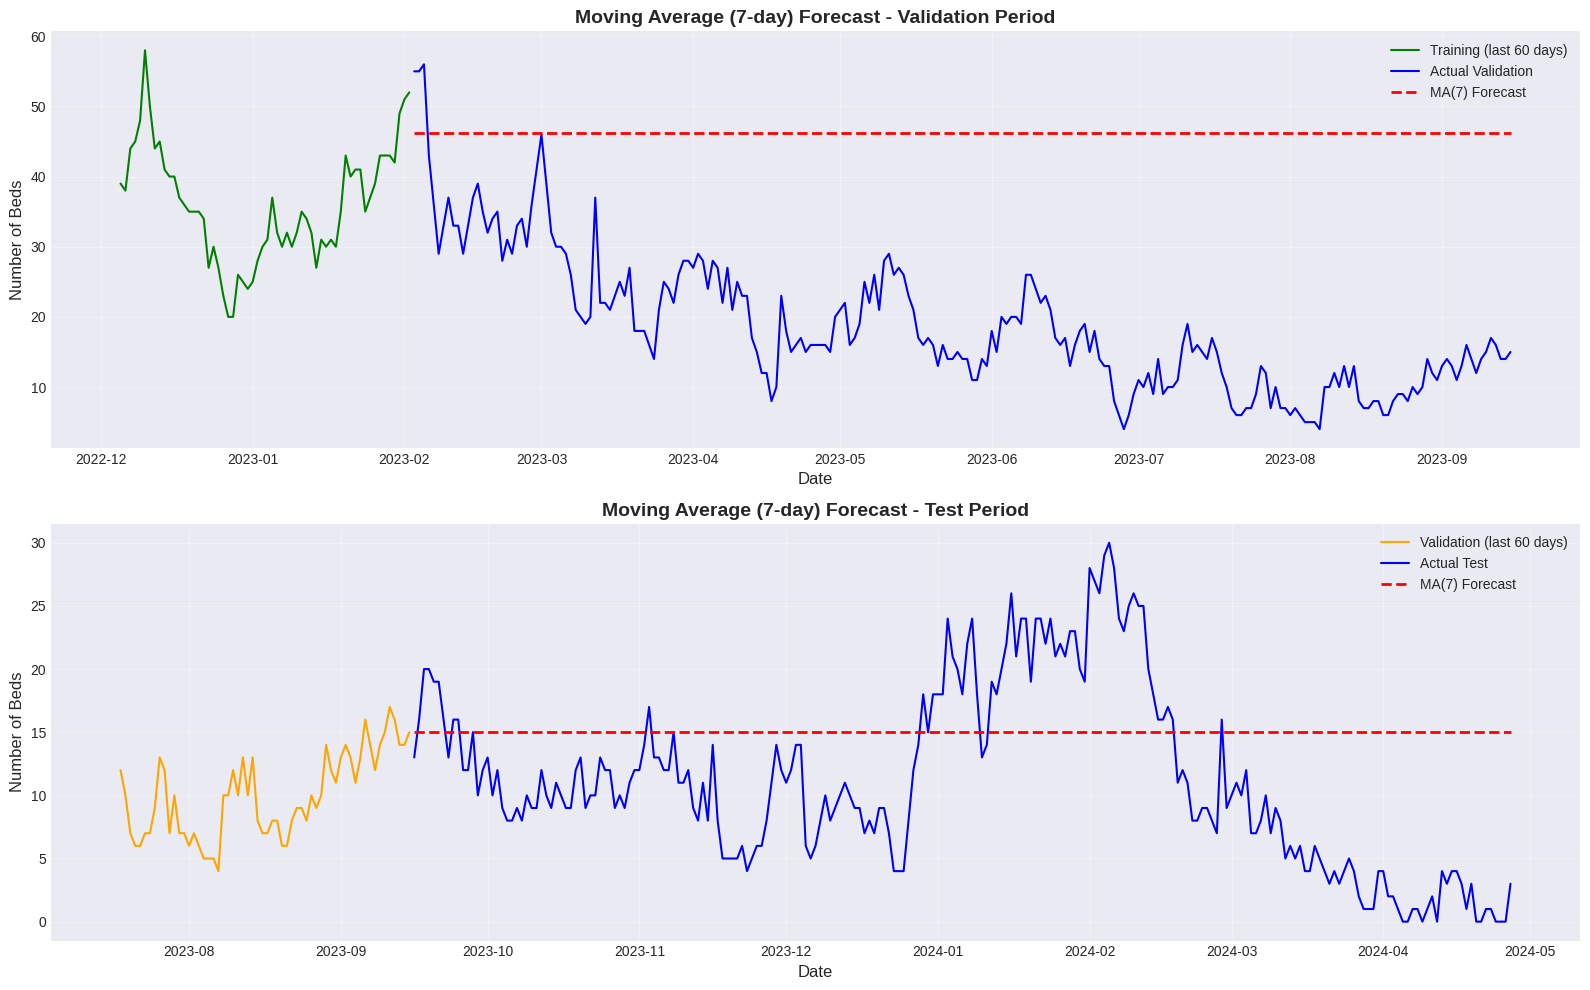

In [82]:
# Moving Average forecast
window_size = 7  # 7-day moving average

# For validation: use last window_size values from training
ma_val = y_train.iloc[-window_size:].mean()
ma_forecast_val = np.full(len(y_val), ma_val)

# For test: use last window_size values from validation (or combine train+val)
combined_train_val = pd.concat([y_train, y_val])
ma_test = combined_train_val.iloc[-window_size:].mean()
ma_forecast_test = np.full(len(y_test), ma_test)

ma_forecast_val_series = pd.Series(ma_forecast_val, index=y_val.index)
ma_forecast_test_series = pd.Series(ma_forecast_test, index=y_test.index)

print(f"Moving Average Forecast (window={window_size} days):")
print(f"Validation forecast: {ma_val:.2f} (constant)")
print(f"Test forecast: {ma_test:.2f} (constant)")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Validation period
axes[0].plot(y_train.index[-60:], y_train.iloc[-60:], label='Training (last 60 days)', color='green', linewidth=1.5)
axes[0].plot(y_val.index, y_val.values, label='Actual Validation', color='blue', linewidth=1.5)
axes[0].plot(y_val.index, ma_forecast_val_series, label=f'MA({window_size}) Forecast', color='red', linestyle='--', linewidth=2)
axes[0].set_title(f'Moving Average ({window_size}-day) Forecast - Validation Period', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Number of Beds', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test period
axes[1].plot(y_val.index[-60:], y_val.iloc[-60:], label='Validation (last 60 days)', color='orange', linewidth=1.5)
axes[1].plot(y_test.index, y_test.values, label='Actual Test', color='blue', linewidth=1.5)
axes[1].plot(y_test.index, ma_forecast_test_series, label=f'MA({window_size}) Forecast', color='red', linestyle='--', linewidth=2)
axes[1].set_title(f'Moving Average ({window_size}-day) Forecast - Test Period', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Number of Beds', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 5.3 Advanced Model 1: ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a classical time series forecasting method.


In [83]:
# Auto-ARIMA parameter selection (using grid search on validation set)
# We'll try a range of parameters and select based on AIC

from itertools import product

def arima_grid_search(ts, p_range, d_range, q_range, max_p=3, max_d=2, max_q=3):
    """
    Perform grid search for ARIMA parameters
    """
    best_aic = np.inf
    best_params = None
    results = []

    # Limit ranges to reasonable values
    p_range = range(min(p_range[0], max_p), min(p_range[1], max_p) + 1)
    d_range = range(min(d_range[0], max_d), min(d_range[1], max_d) + 1)
    q_range = range(min(q_range[0], max_q), min(q_range[1], max_q) + 1)

    for p, d, q in product(p_range, d_range, q_range):
        try:
            model = ARIMA(ts, order=(p, d, q))
            fitted_model = model.fit()
            aic = fitted_model.aic
            results.append({'p': p, 'd': d, 'q': q, 'aic': aic})

            if aic < best_aic:
                best_aic = aic
                best_params = (p, d, q)
        except:
            continue

    return best_params, best_aic, results

print("Performing ARIMA parameter grid search...")
print("This may take a few minutes...")

# Perform grid search on training data
best_params, best_aic, grid_results = arima_grid_search(
    y_train,
    p_range=(0, 3),
    d_range=(0, 2),
    q_range=(0, 3)
)

print(f"\nBest ARIMA parameters: {best_params}")
print(f"Best AIC: {best_aic:.2f}")

# Fit ARIMA model with best parameters
arima_model = ARIMA(y_train, order=best_params)
arima_fitted = arima_model.fit()

print("\nARIMA Model Summary:")
print("=" * 50)
print(arima_fitted.summary())


Performing ARIMA parameter grid search...
This may take a few minutes...

Best ARIMA parameters: (2, 1, 3)
Best AIC: 7101.06

ARIMA Model Summary:
                                   SARIMAX Results                                   
Dep. Variable:     inpatient_beds_used_covid   No. Observations:                 1047
Model:                        ARIMA(2, 1, 3)   Log Likelihood               -3544.530
Date:                       Wed, 26 Nov 2025   AIC                           7101.059
Time:                               02:28:57   BIC                           7130.776
Sample:                           03-23-2020   HQIC                          7112.329
                                - 02-02-2023                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1  

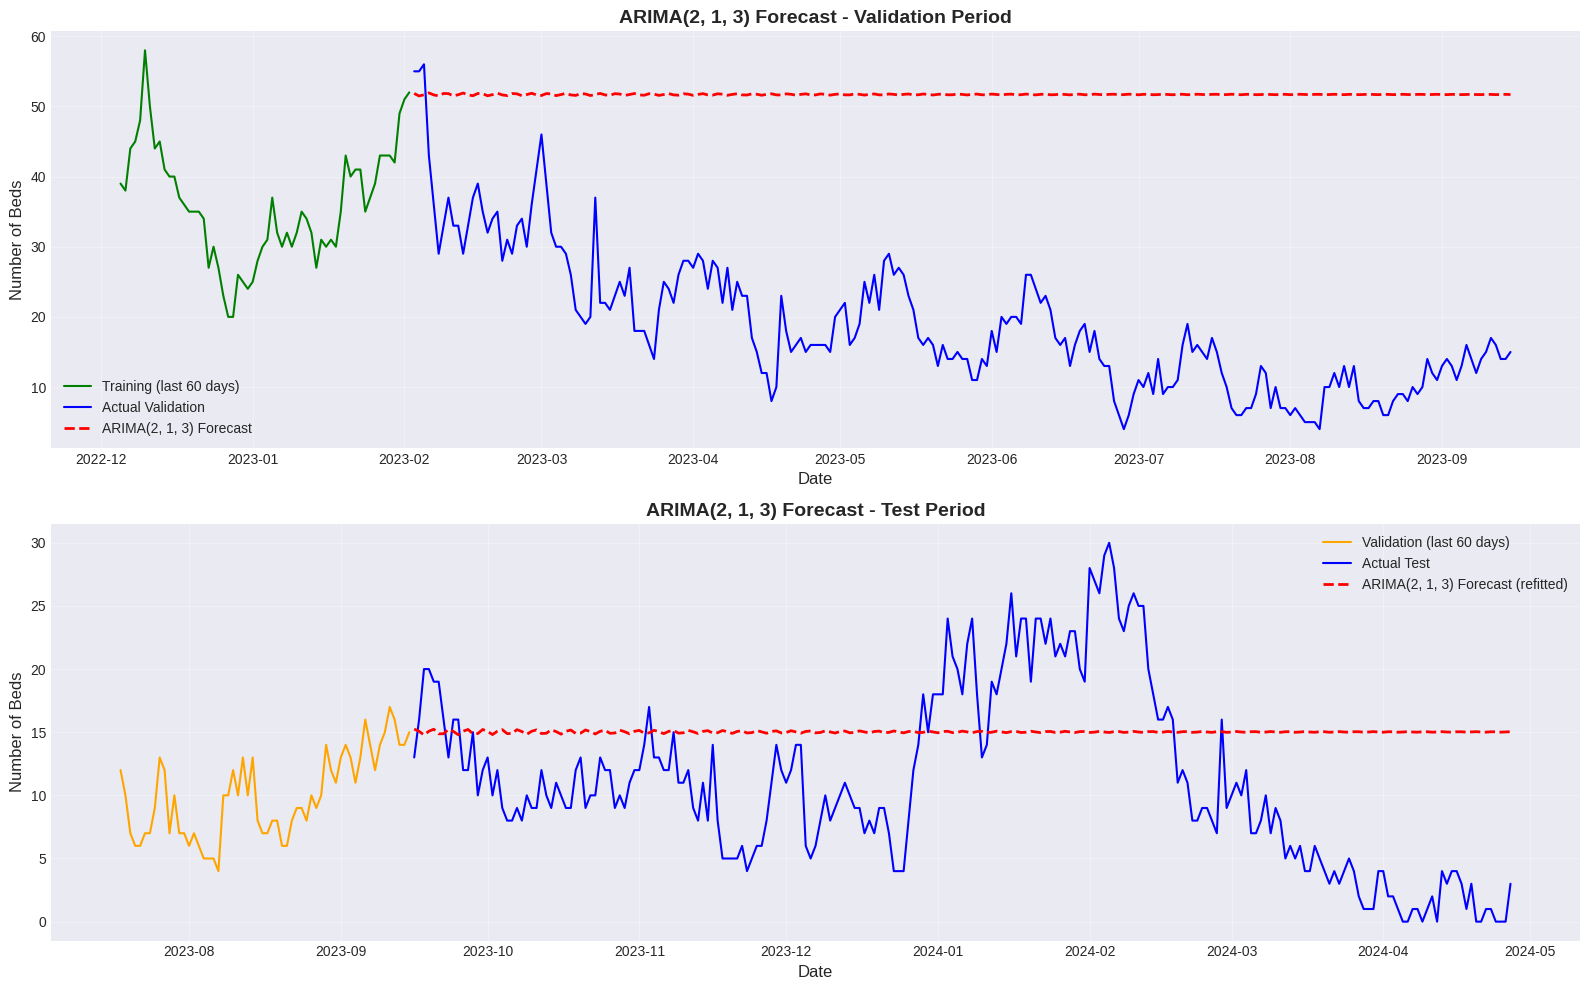

In [84]:
# Generate forecasts
arima_forecast_val = arima_fitted.forecast(steps=len(y_val))
arima_forecast_test = arima_fitted.forecast(steps=len(y_test))

# Update model with validation data for test forecast (refit)
# For better test forecasts, we can refit on train+val
arima_model_full = ARIMA(pd.concat([y_train, y_val]), order=best_params)
arima_fitted_full = arima_model_full.fit()
arima_forecast_test_refitted = arima_fitted_full.forecast(steps=len(y_test))

# Create forecast series
arima_forecast_val_series = pd.Series(arima_forecast_val.values, index=y_val.index)
arima_forecast_test_series = pd.Series(arima_forecast_test.values, index=y_test.index)
arima_forecast_test_refitted_series = pd.Series(arima_forecast_test_refitted.values, index=y_test.index)

# Visualize ARIMA forecasts
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Validation period
axes[0].plot(y_train.index[-60:], y_train.iloc[-60:], label='Training (last 60 days)', color='green', linewidth=1.5)
axes[0].plot(y_val.index, y_val.values, label='Actual Validation', color='blue', linewidth=1.5)
axes[0].plot(y_val.index, arima_forecast_val_series, label=f'ARIMA{best_params} Forecast', color='red', linestyle='--', linewidth=2)
axes[0].set_title(f'ARIMA{best_params} Forecast - Validation Period', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Number of Beds', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test period
axes[1].plot(y_val.index[-60:], y_val.iloc[-60:], label='Validation (last 60 days)', color='orange', linewidth=1.5)
axes[1].plot(y_test.index, y_test.values, label='Actual Test', color='blue', linewidth=1.5)
axes[1].plot(y_test.index, arima_forecast_test_refitted_series, label=f'ARIMA{best_params} Forecast (refitted)', color='red', linestyle='--', linewidth=2)
axes[1].set_title(f'ARIMA{best_params} Forecast - Test Period', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Number of Beds', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 5.4 Advanced Model 2: Random Forest (Machine Learning)

Random Forest can capture non-linear patterns and interactions in the data.


In [85]:
# Feature engineering for Random Forest
def create_lag_features(series, max_lag=14):
    """
    Create lag features for time series forecasting
    """
    df_features = pd.DataFrame()
    df_features['target'] = series.values

    # Create lag features
    for lag in range(1, max_lag + 1):
        df_features[f'lag_{lag}'] = series.shift(lag).values

    # Create rolling statistics
    df_features['rolling_mean_7'] = series.rolling(window=7).mean().values
    df_features['rolling_mean_30'] = series.rolling(window=30).mean().values
    df_features['rolling_std_7'] = series.rolling(window=7).std().values

    # Date-based features
    df_features['day_of_week'] = series.index.dayofweek
    df_features['month'] = series.index.month
    df_features['day_of_year'] = series.index.dayofyear

    return df_features.dropna()

# Create features for training
print("Creating features for Random Forest model...")
train_features = create_lag_features(y_train, max_lag=14)
X_train = train_features.drop('target', axis=1)
y_train_rf = train_features['target']

print(f"Training features shape: {X_train.shape}")
print(f"Feature names: {list(X_train.columns)}")


Creating features for Random Forest model...
Training features shape: (1018, 20)
Feature names: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'rolling_mean_7', 'rolling_mean_30', 'rolling_std_7', 'day_of_week', 'month', 'day_of_year']


In [86]:
# Train Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train_rf)

print("Random Forest model trained successfully!")
print(f"Feature importances (top 10):")
feature_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importance.head(10))


Random Forest model trained successfully!
Feature importances (top 10):
lag_1              0.900869
rolling_mean_7     0.062316
lag_2              0.024402
rolling_std_7      0.001689
day_of_year        0.001123
rolling_mean_30    0.001030
lag_3              0.000828
lag_8              0.000773
lag_7              0.000759
day_of_week        0.000705
dtype: float64


Generating Random Forest forecasts for validation set...
Generating Random Forest forecasts for test set...


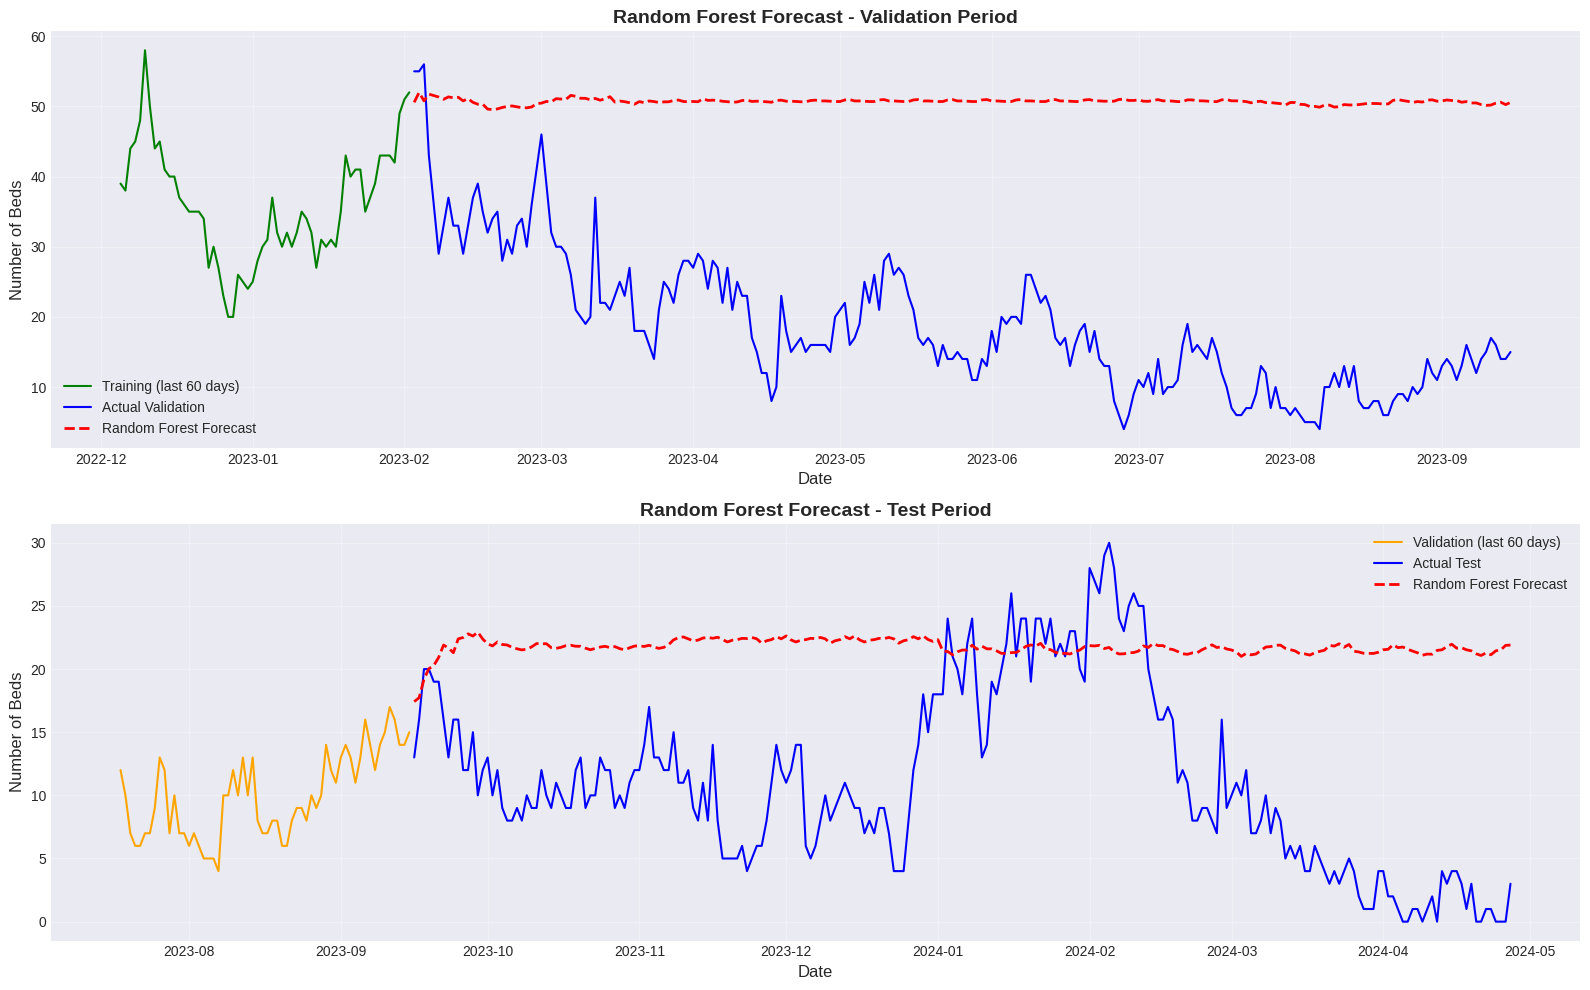

In [87]:
# Generate forecasts using rolling window approach
def generate_rf_forecast(model, series, forecast_steps, max_lag=14):
    """
    Generate multi-step ahead forecasts using Random Forest with rolling window
    """
    forecasts = []
    current_series = series.copy()

    for step in range(forecast_steps):
        # Create features for next prediction
        features = create_lag_features(current_series, max_lag=max_lag)
        if len(features) == 0:
            # Fallback: use last available value
            pred = current_series.iloc[-1]
        else:
            X_pred = features.drop('target', axis=1).iloc[-1:].values
            pred = model.predict(X_pred)[0]

        forecasts.append(pred)

        # Update series with prediction (for next step)
        next_date = current_series.index[-1] + pd.Timedelta(days=1)
        current_series = pd.concat([current_series, pd.Series([pred], index=[next_date])])

    return np.array(forecasts)

print("Generating Random Forest forecasts for validation set...")
rf_forecast_val = generate_rf_forecast(rf_model, y_train, len(y_val), max_lag=14)
rf_forecast_val_series = pd.Series(rf_forecast_val, index=y_val.index)

# For test set, use train+val as history
combined_train_val = pd.concat([y_train, y_val])
print("Generating Random Forest forecasts for test set...")
rf_forecast_test = generate_rf_forecast(rf_model, combined_train_val, len(y_test), max_lag=14)
rf_forecast_test_series = pd.Series(rf_forecast_test, index=y_test.index)

# Visualize Random Forest forecasts
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Validation period
axes[0].plot(y_train.index[-60:], y_train.iloc[-60:], label='Training (last 60 days)', color='green', linewidth=1.5)
axes[0].plot(y_val.index, y_val.values, label='Actual Validation', color='blue', linewidth=1.5)
axes[0].plot(y_val.index, rf_forecast_val_series, label='Random Forest Forecast', color='red', linestyle='--', linewidth=2)
axes[0].set_title('Random Forest Forecast - Validation Period', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Number of Beds', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test period
axes[1].plot(y_val.index[-60:], y_val.iloc[-60:], label='Validation (last 60 days)', color='orange', linewidth=1.5)
axes[1].plot(y_test.index, y_test.values, label='Actual Test', color='blue', linewidth=1.5)
axes[1].plot(y_test.index, rf_forecast_test_series, label='Random Forest Forecast', color='red', linestyle='--', linewidth=2)
axes[1].set_title('Random Forest Forecast - Test Period', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Number of Beds', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Model Evaluation

We'll evaluate all models using multiple metrics:
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)
- **MAPE** (Mean Absolute Percentage Error) - scale-free metric


In [88]:
# Define evaluation functions
def calculate_metrics(y_true, y_pred, model_name=""):
    """
    Calculate comprehensive evaluation metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # MAPE (Mean Absolute Percentage Error) - scale-free
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # MASE (Mean Absolute Scaled Error) - another scale-free metric
    # Using naive forecast as baseline
    naive_error = np.mean(np.abs(np.diff(y_true)))
    if naive_error == 0:
        mase = np.inf
    else:
        mase = mae / naive_error

    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'MASE': mase
    }

    return metrics

# Store all forecasts
forecasts_val = {
    'Naive': naive_forecast_val_series,
    'Moving Average': ma_forecast_val_series,
    'ARIMA': arima_forecast_val_series,
    'Random Forest': rf_forecast_val_series
}

forecasts_test = {
    'Naive': naive_forecast_test_series,
    'Moving Average': ma_forecast_test_series,
    'ARIMA': arima_forecast_test_refitted_series,
    'Random Forest': rf_forecast_test_series
}

# Evaluate on validation set
print("=" * 70)
print("VALIDATION SET EVALUATION")
print("=" * 70)

val_results = {}
for model_name, forecast in forecasts_val.items():
    metrics = calculate_metrics(y_val, forecast, model_name)
    val_results[model_name] = metrics
    print(f"\n{model_name}:")
    print(f"  MAE:  {metrics['MAE']:.2f}")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print(f"  MASE: {metrics['MASE']:.4f}")

# Evaluate on test set
print("\n" + "=" * 70)
print("TEST SET EVALUATION")
print("=" * 70)

test_results = {}
for model_name, forecast in forecasts_test.items():
    metrics = calculate_metrics(y_test, forecast, model_name)
    test_results[model_name] = metrics
    print(f"\n{model_name}:")
    print(f"  MAE:  {metrics['MAE']:.2f}")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print(f"  MASE: {metrics['MASE']:.4f}")


VALIDATION SET EVALUATION

Naive:
  MAE:  33.44
  RMSE: 34.73
  MAPE: 269.32%
  MASE: 13.0954

Moving Average:
  MAE:  27.74
  RMSE: 29.15
  MAPE: 228.03%
  MASE: 10.8628

ARIMA:
  MAE:  33.15
  RMSE: 34.44
  MAPE: 267.21%
  MASE: 12.9810

Random Forest:
  MAE:  32.16
  RMSE: 33.47
  MAPE: 259.78%
  MASE: 12.5934

TEST SET EVALUATION

Naive:
  MAE:  7.02
  RMSE: 8.09
  MAPE: inf%
  MASE: 3.8719

Moving Average:
  MAE:  7.02
  RMSE: 8.09
  MAPE: inf%
  MASE: 3.8719

ARIMA:
  MAE:  7.03
  RMSE: 8.10
  MAPE: inf%
  MASE: 3.8809

Random Forest:
  MAE:  11.27
  RMSE: 12.78
  MAPE: inf%
  MASE: 6.2203


In [89]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': [],
    'Set': [],
    'MAE': [],
    'RMSE': [],
    'MAPE': [],
    'MASE': []
})

for model_name in val_results.keys():
    comparison_df = pd.concat([
        comparison_df,
        pd.DataFrame({
            'Model': [model_name],
            'Set': ['Validation'],
            'MAE': [val_results[model_name]['MAE']],
            'RMSE': [val_results[model_name]['RMSE']],
            'MAPE': [val_results[model_name]['MAPE']],
            'MASE': [val_results[model_name]['MASE']]
        })
    ], ignore_index=True)

    comparison_df = pd.concat([
        comparison_df,
        pd.DataFrame({
            'Model': [model_name],
            'Set': ['Test'],
            'MAE': [test_results[model_name]['MAE']],
            'RMSE': [test_results[model_name]['RMSE']],
            'MAPE': [test_results[model_name]['MAPE']],
            'MASE': [test_results[model_name]['MASE']]
        })
    ], ignore_index=True)

print("\nComplete Comparison Table:")
print("=" * 70)
print(comparison_df.to_string(index=False))



Complete Comparison Table:
         Model        Set       MAE      RMSE       MAPE      MASE
         Naive Validation 33.440000 34.733141 269.324955 13.095385
         Naive       Test  7.017778  8.091422        inf  3.871877
Moving Average Validation 27.739048 29.154979 228.025533 10.862844
Moving Average       Test  7.017778  8.091422        inf  3.871877
         ARIMA Validation 33.147825 34.444140 267.205543 12.980967
         ARIMA       Test  7.034140  8.104453        inf  3.880905
 Random Forest Validation 32.158042 33.468631 259.776580 12.593359
 Random Forest       Test 11.274316 12.779019        inf  6.220312


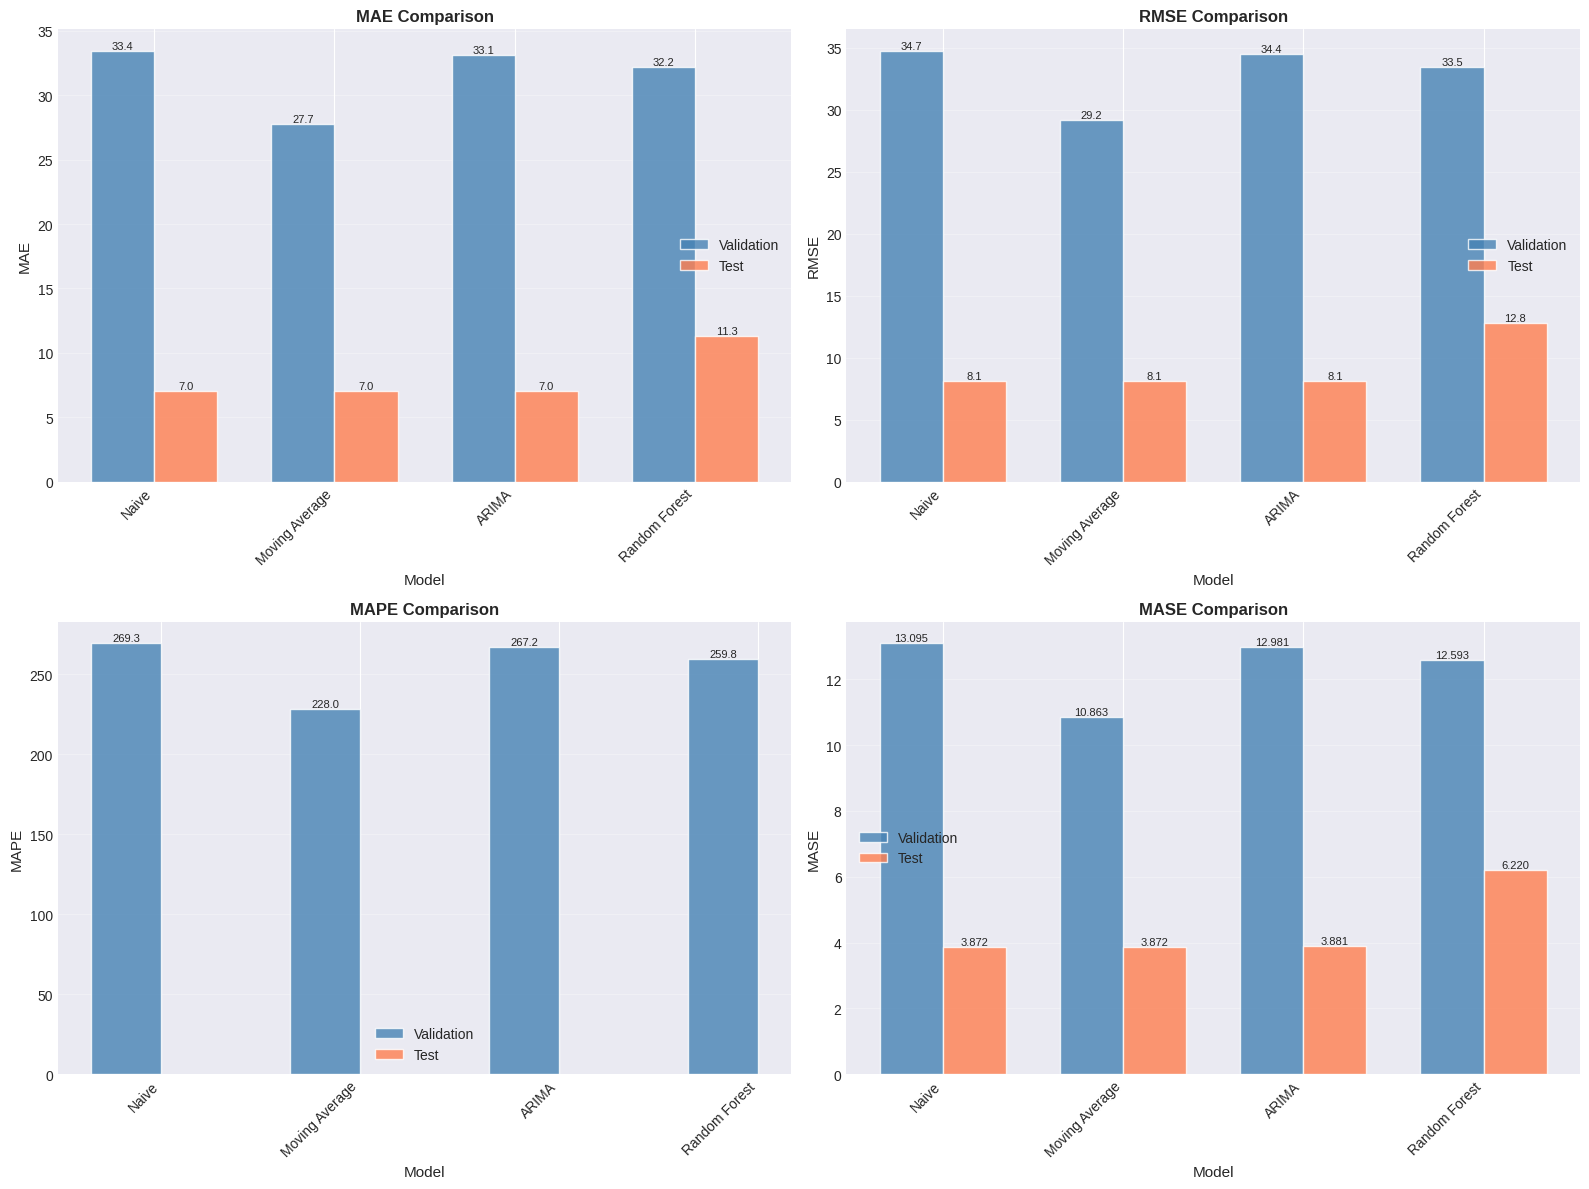

In [90]:
# Visualize metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['MAE', 'RMSE', 'MAPE', 'MASE']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]

    models = list(val_results.keys())
    val_values = [val_results[m][metric] for m in models]
    test_values = [test_results[m][metric] for m in models]

    x = np.arange(len(models))
    width = 0.35

    bars1 = ax.bar(x - width/2, val_values, width, label='Validation', alpha=0.8, color='steelblue')
    bars2 = ax.bar(x + width/2, test_values, width, label='Test', alpha=0.8, color='coral')

    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}' if metric != 'MASE' else f'{height:.3f}',
                   ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


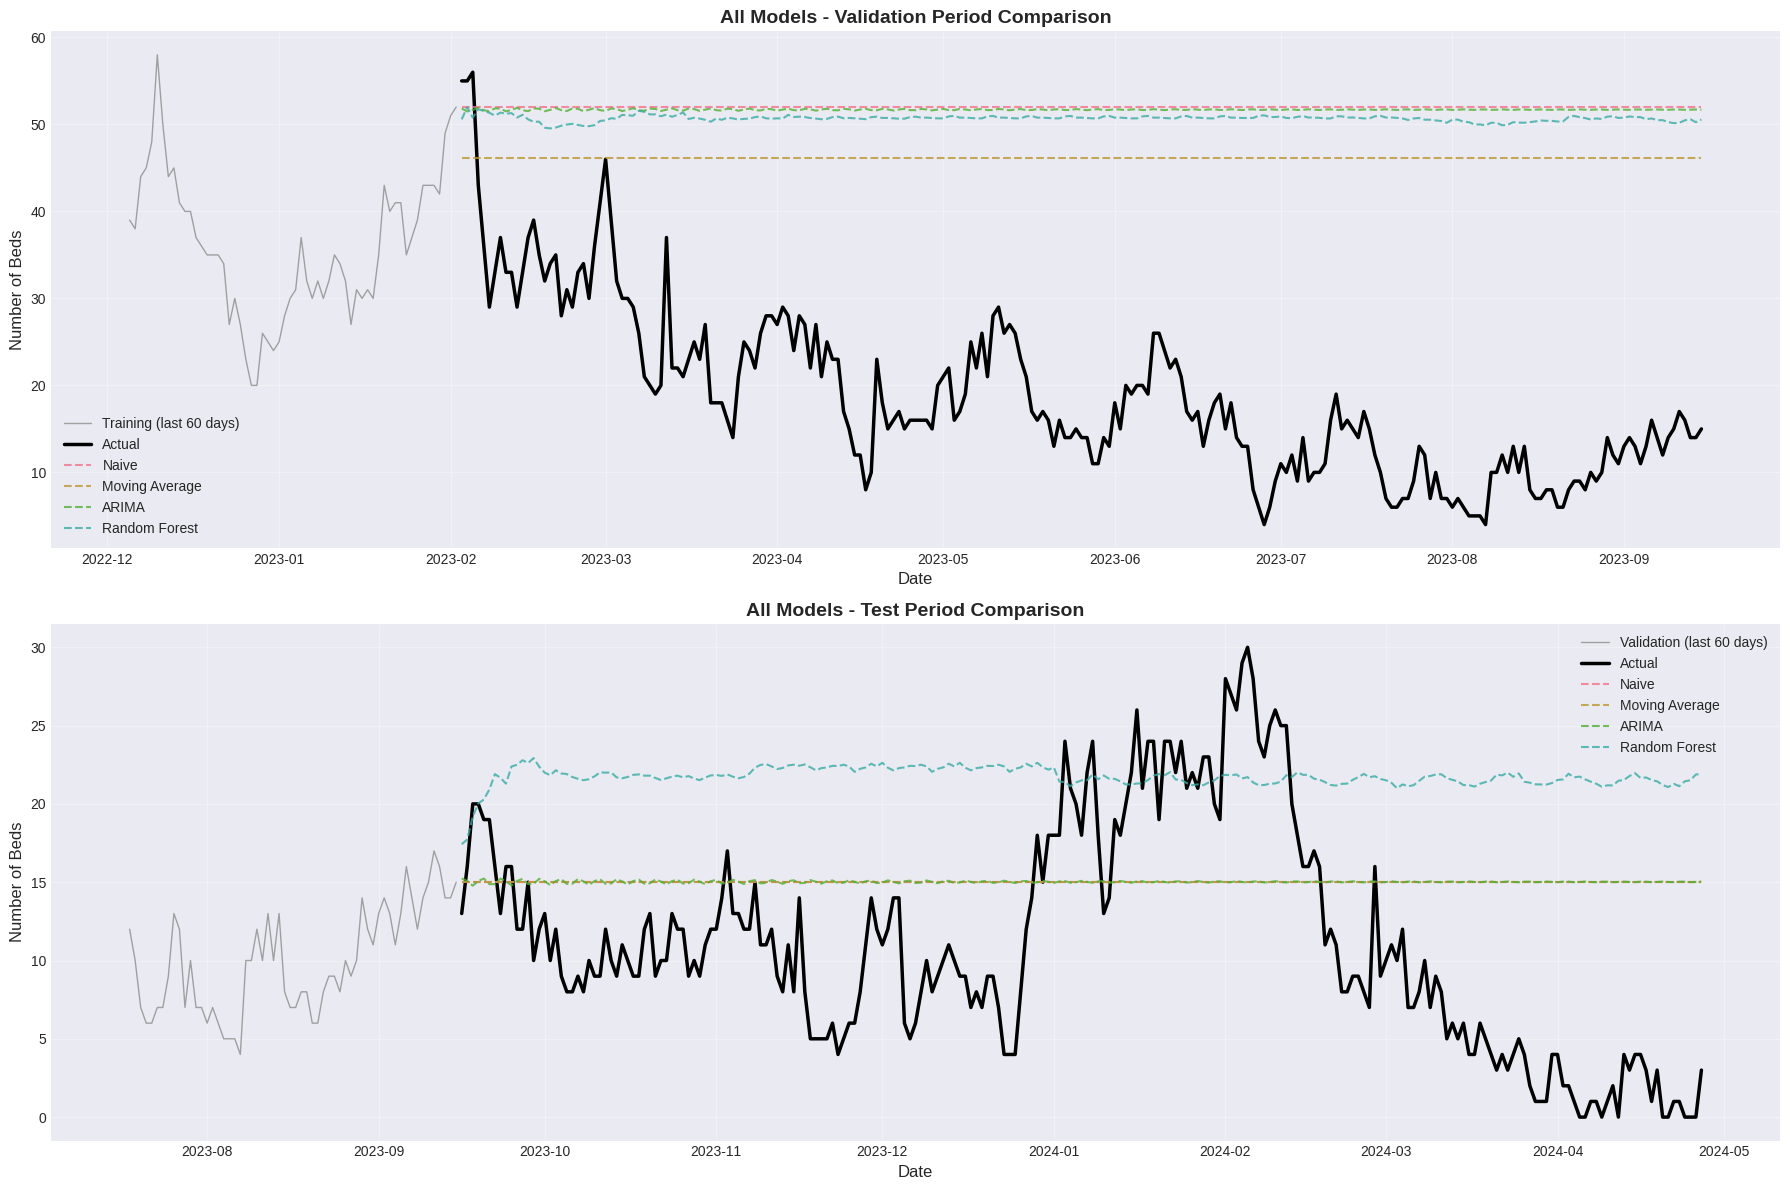

In [91]:
# Visualize all forecasts together for comparison
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Validation period - all models
axes[0].plot(y_train.index[-60:], y_train.iloc[-60:], label='Training (last 60 days)', color='gray', linewidth=1, alpha=0.7)
axes[0].plot(y_val.index, y_val.values, label='Actual', color='black', linewidth=2.5)
axes[0].plot(y_val.index, naive_forecast_val_series, label='Naive', linestyle='--', linewidth=1.5, alpha=0.8)
axes[0].plot(y_val.index, ma_forecast_val_series, label='Moving Average', linestyle='--', linewidth=1.5, alpha=0.8)
axes[0].plot(y_val.index, arima_forecast_val_series, label='ARIMA', linestyle='--', linewidth=1.5, alpha=0.8)
axes[0].plot(y_val.index, rf_forecast_val_series, label='Random Forest', linestyle='--', linewidth=1.5, alpha=0.8)
axes[0].set_title('All Models - Validation Period Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Number of Beds', fontsize=12)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Test period - all models
axes[1].plot(y_val.index[-60:], y_val.iloc[-60:], label='Validation (last 60 days)', color='gray', linewidth=1, alpha=0.7)
axes[1].plot(y_test.index, y_test.values, label='Actual', color='black', linewidth=2.5)
axes[1].plot(y_test.index, naive_forecast_test_series, label='Naive', linestyle='--', linewidth=1.5, alpha=0.8)
axes[1].plot(y_test.index, ma_forecast_test_series, label='Moving Average', linestyle='--', linewidth=1.5, alpha=0.8)
axes[1].plot(y_test.index, arima_forecast_test_refitted_series, label='ARIMA', linestyle='--', linewidth=1.5, alpha=0.8)
axes[1].plot(y_test.index, rf_forecast_test_series, label='Random Forest', linestyle='--', linewidth=1.5, alpha=0.8)
axes[1].set_title('All Models - Test Period Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Number of Beds', fontsize=12)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 6.1 Short-term vs Long-term Performance

Now we analyze how model performance changes over different forecast horizons.


Short-term vs Long-term Performance Analysis (Test Set)

Naive:
  Short-term (first 112 days):
    MAE: 4.97, RMSE: 5.70, MAPE: 63.39%
  Long-term (last 113 days):
    MAE: 9.04, RMSE: 9.90, MAPE: inf%
  Performance degradation (MAE): 81.9%

Moving Average:
  Short-term (first 112 days):
    MAE: 4.97, RMSE: 5.70, MAPE: 63.39%
  Long-term (last 113 days):
    MAE: 9.04, RMSE: 9.90, MAPE: inf%
  Performance degradation (MAE): 81.9%

ARIMA:
  Short-term (first 112 days):
    MAE: 5.00, RMSE: 5.73, MAPE: 63.68%
  Long-term (last 113 days):
    MAE: 9.05, RMSE: 9.91, MAPE: inf%
  Performance degradation (MAE): 80.9%

Random Forest:
  Short-term (first 112 days):
    MAE: 10.99, RMSE: 11.81, MAPE: 133.02%
  Long-term (last 113 days):
    MAE: 11.56, RMSE: 13.67, MAPE: inf%
  Performance degradation (MAE): 5.2%


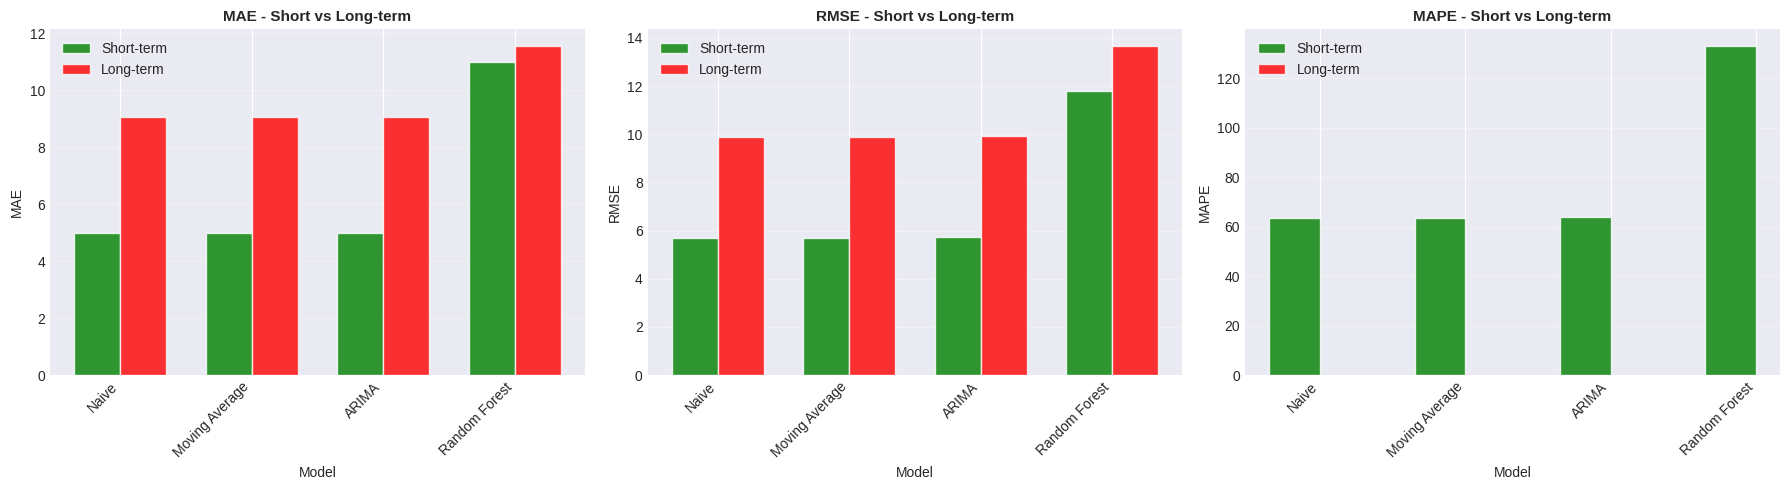

In [92]:
# Analyze short-term vs long-term performance
# Divide test set into short-term (first half) and long-term (second half)
test_midpoint = len(y_test) // 2
y_test_short = y_test.iloc[:test_midpoint]
y_test_long = y_test.iloc[test_midpoint:]

print("Short-term vs Long-term Performance Analysis (Test Set)")
print("=" * 70)

short_term_results = {}
long_term_results = {}

for model_name in forecasts_test.keys():
    forecast = forecasts_test[model_name]
    forecast_short = forecast.iloc[:test_midpoint]
    forecast_long = forecast.iloc[test_midpoint:]

    metrics_short = calculate_metrics(y_test_short, forecast_short)
    metrics_long = calculate_metrics(y_test_long, forecast_long)

    short_term_results[model_name] = metrics_short
    long_term_results[model_name] = metrics_long

    print(f"\n{model_name}:")
    print(f"  Short-term (first {len(y_test_short)} days):")
    print(f"    MAE: {metrics_short['MAE']:.2f}, RMSE: {metrics_short['RMSE']:.2f}, MAPE: {metrics_short['MAPE']:.2f}%")
    print(f"  Long-term (last {len(y_test_long)} days):")
    print(f"    MAE: {metrics_long['MAE']:.2f}, RMSE: {metrics_long['RMSE']:.2f}, MAPE: {metrics_long['MAPE']:.2f}%")
    print(f"  Performance degradation (MAE): {((metrics_long['MAE'] - metrics_short['MAE']) / metrics_short['MAE'] * 100):.1f}%")

# Visualize short-term vs long-term comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_compare = ['MAE', 'RMSE', 'MAPE']
for idx, metric in enumerate(metrics_to_compare):
    models = list(short_term_results.keys())
    short_values = [short_term_results[m][metric] for m in models]
    long_values = [long_term_results[m][metric] for m in models]

    x = np.arange(len(models))
    width = 0.35

    axes[idx].bar(x - width/2, short_values, width, label='Short-term', alpha=0.8, color='green')
    axes[idx].bar(x + width/2, long_values, width, label='Long-term', alpha=0.8, color='red')

    axes[idx].set_xlabel('Model', fontsize=10)
    axes[idx].set_ylabel(metric, fontsize=10)
    axes[idx].set_title(f'{metric} - Short vs Long-term', fontsize=11, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(models, rotation=45, ha='right')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
